In [1]:
from os import path, getcwd
import numpy as np
import re
from IPython.display import display, HTML

In [2]:
# !rm -r ./mecode_viewer/
# !git clone https://github.com/rtellez700/mecode_viewer.git

In [3]:
# file_name = 'Dogbone_parallel_26C_700um_10psi_0.241mms__prod'
# file_name = 'Dogbone_perp_26C_700um_10psi_0.241mms__prod'
file_name = 'Dogbone_parallel_26C_700um_64psi_2.677mms__prod'
# file_name = 'Dogbone_perp_26C_700um_64psi_2.677mms__prod'

input_file  = path.join(getcwd(), 'gcode', f'{file_name}.gcode')
output_file = path.join(getcwd(), 'gcode_prod', f'{file_name}_final.pgm')

In [4]:
input_file

'/Users/tellesarriag1/OneDrive - LLNL/DIW 3DP/dogbone/gcode/Dogbone_parallel_26C_700um_64psi_2.677mms__prod.gcode'

In [5]:
output_file

'/Users/tellesarriag1/OneDrive - LLNL/DIW 3DP/dogbone/gcode_prod/Dogbone_parallel_26C_700um_64psi_2.677mms__prod_final.pgm'

## Utility Functions

In [6]:
def remove_line(line):
    return '; >>> ' + line + ' ; REMOVED'

## Print Conditions

In [7]:
d_N = 0.700 # mm
v_N = 2.4 # mm/s
jog_speed = 15 # mm/s
jog_height = 10 # mm
# H = 0.25
dz = d_N*0.8
P = 25 # psi

dwell_initial = np.round(d_N/v_N * 0.7 ,2) # seconds

ACCEL_DEFAULT = 250 # mm/s^2
DECEL_DEFAULT = 500 # mm/s^2


In [8]:
dwell_initial_cmd = f'G4 P{dwell_initial}' if dwell_initial >= 0.3 else ''

print(dwell_initial_cmd)

In [9]:
TOGGLE_P_ON = 'Call togglePress P5; toggle on'
TOGGLE_P_OFF = 'Call togglePress P5; toggle off'

In [10]:
contents = open(input_file, "r").read().splitlines()

In [11]:
# contents

### Misc other rules

In [12]:
for j, line in enumerate(contents):
    
    # remove Extrude `E` commands
    re_E_pattern = r"E[+-]?[0-9]+\.[0-9]+"
    contents[j] = re.sub(re_E_pattern, "", line)
    
    # remove all initial P_ON / P_OFF lines
    if 'Call togglePress P5' in line:
#         contents[j] = remove_line(line)
        contents[j] = ""
        
    # remove initial home move
#     if '; move to first infill point' in line:
#         contents[j] = remove_line(line)
    
    # reset HOME POSITION
    if 'move to next layer (0)' in line:
        contents[j] = 'G92 X0 Y0  ; RESET X,Y HOME POSITION TO CURRENT POSITION\n' + line + '\n'

    # change acceleration / deceleration
    if 'G65 F2000;' in line:
        contents[j] = f'G65 F{ACCEL_DEFAULT}; DEFAULT ACCEL RATE'

    if 'G66 F2000' in line:
        contents[j] = f'G65 F{DECEL_DEFAULT}; DEFAULT ACCEL RATE'
        
    # remove M83
    if 'M83' in line:
        contents[j] = remove_line(line)

In [13]:
for j, line in enumerate(contents):
    
    # ADD P_ON COMMAND
    if 'move to next layer (0)' in line:
        contents[j] = line + '\n' + TOGGLE_P_ON + '\n'
        
    if ';END gcode for filament' in line:
        contents[j] = line + '\n\n' + TOGGLE_P_OFF + '\n'

#### CHECK FOR ERRORS

In [14]:
count_P_ON  = np.sum([l == TOGGLE_P_ON for l in contents])
count_P_OFF = np.sum([l == TOGGLE_P_OFF for l in contents])

if count_P_ON == count_P_OFF:
    display(HTML('<h3>check: togglePress calls --> PASS</h3>'))
else:
    print('check: togglePress calls --> FAILED')

### Prepend

In [15]:
prepend_contents = open('aerotech_prepend.txt', "r").read().splitlines()
contents = prepend_contents + [f'Call setPress P5 Q{P}'] + contents

### Append

In [16]:
append_contents = open('aerotech_append.txt', "r").read().splitlines()
contents = contents + append_contents

## Output to a file

In [17]:
with open(output_file, 'w') as f:
    for line in contents:
        f.write("%s\n" % line)

In [18]:
output_file

'/Users/tellesarriag1/OneDrive - LLNL/DIW 3DP/dogbone/gcode_prod/Dogbone_parallel_26C_700um_64psi_2.677mms__prod_final.pgm'

---

In [19]:
import mecode_viewer.mecode_viewer.main as gcode_viewer

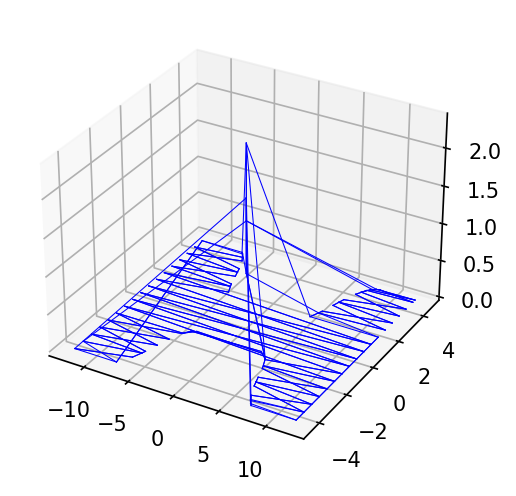

In [20]:
gcode_viewer.mecode_viewer(output_file)